## Task 2 - Model Building and Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import mlflow
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from scripts.model_utils import *

In [4]:
# Load fraud data
fraud_data = pd.read_csv('../data/processed/processed_fraud_data.csv')
# Load credit card data
credit_data = pd.read_csv('../data/processed/processed_credit_card.csv')

In [5]:
fraud_data.head()

,user_id,purchase_value,device_id,age,ip_address,class,ip_int,hour_of_day,day_of_week,month,...,country_Zambia,country_Zimbabwe,signup_hour,signup_day,signup_year,signup_month,purchase_hour,purchase_day,purchase_year,purchase_month
0,247547,0.549607,46780,-0.363124,-1.728724,0,-1.728724,-1.231124,1.487911,0.749993,...,False,False,22,1,2015,2,2,5,2015,4
1,220737,-1.197335,70073,0.101168,-1.728666,0,-1.728666,1.229002,-0.505034,-1.500438,...,False,False,20,6,2015,6,1,0,2015,6
2,390400,0.385831,53448,-0.479197,-1.728664,0,-1.728664,1.663142,0.989675,-0.750295,...,False,False,18,3,2015,1,18,3,2015,1
3,69592,0.986342,92195,-0.363124,-1.728577,0,-1.728577,0.650149,0.989675,-0.375223,...,False,False,21,1,2015,4,13,0,2015,5
4,174987,0.767974,107434,0.449387,-1.728546,0,-1.728546,-1.086411,-1.003270,1.875208,...,False,False,7,1,2015,7,18,2,2015,9


In [6]:
credit_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996823,-0.701082,-0.041687,1.680101,0.976623,-0.247020,0.348012,0.193700,0.084434,0.333534,...,-0.024777,0.383483,-0.177444,0.110157,0.247059,-0.392622,0.333033,-0.065850,0.244200,0
1,-1.996823,0.608792,0.164138,0.109279,0.318998,0.042258,-0.060980,-0.065656,0.072903,-0.231703,...,-0.311372,-0.881454,0.162081,-0.561503,0.321175,0.260854,-0.027154,0.043219,-0.342584,0
2,-1.996802,-0.700336,-0.811337,1.174270,0.270648,-0.366756,1.352655,0.643223,0.210788,-1.381169,...,0.343094,1.065068,1.457772,-1.138484,-0.628161,-0.288861,-0.144325,-0.183824,1.158900,0
3,-1.996802,-0.499064,-0.109972,1.187383,-0.608355,-0.008814,0.937245,0.192079,0.320843,-1.264664,...,-0.149093,0.007299,-0.305465,-1.941446,1.242487,-0.460694,0.154039,0.185687,0.139886,0
4,-1.996781,-0.597606,0.535539,1.025470,0.287092,-0.297036,0.072873,0.481517,-0.228725,0.747917,...,-0.012516,1.101780,-0.220709,0.232904,-0.394800,1.041677,0.550001,0.654234,-0.073813,0


In [7]:
print(fraud_data.isnull().sum())

user_id           0
purchase_value    0
device_id         0
age               0
ip_address        0
                 ..
signup_month      0
purchase_hour     0
purchase_day      0
purchase_year     0
purchase_month    0
Length: 212, dtype: int64


In [8]:
fraud_data.dtypes

user_id             int64
purchase_value    float64
device_id           int64
age               float64
ip_address        float64
                   ...   
signup_month        int64
purchase_hour       int64
purchase_day        int64
purchase_year       int64
purchase_month      int64
Length: 212, dtype: object

In [9]:
fraud_data.columns

Index(['user_id', 'purchase_value', 'device_id', 'age', 'ip_address', 'class',
       'ip_int', 'hour_of_day', 'day_of_week', 'month',
       ...
       'country_Zambia', 'country_Zimbabwe', 'signup_hour', 'signup_day',
       'signup_year', 'signup_month', 'purchase_hour', 'purchase_day',
       'purchase_year', 'purchase_month'],
      dtype='object', length=212)

In [10]:
credit_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:
#Initialize MLflow experiment
mlflow.set_experiment("fraud_detection_comparison")

<Experiment: artifact_location='file:///d:/KIFYA%20AIM/WEEK%208%20AND%209/project/fraud-detection-system/notebooks/mlruns/743817608207788903', creation_time=1729453842785, experiment_id='743817608207788903', last_update_time=1729453842785, lifecycle_stage='active', name='fraud_detection_comparison', tags={}>

In [12]:
# Initialize the modeling class for both datasets
fraud_detector_ecommerce = FraudDetectionModeling(experiment_name="ecommerce_fraud_detection")
fraud_detector_credit = FraudDetectionModeling(experiment_name="credit_fraud_detection")

In [13]:
# # Encode Categorical Features
# from sklearn.preprocessing import LabelEncoder
# categorical_columns = ['device_id','age_group']
# le = LabelEncoder()
# for col in categorical_columns:
#     fraud_data[col] = le.fit_transform(fraud_data[col])

### Prepare features and target for both datasets

In [15]:
# model training on specific columns you want to include in X_fraud input 
selected_features = ['user_id', 'purchase_value', 'device_id', 'age','ip_address','ip_int',
                     'hour_of_day','day_of_week','is_weekend','time_to_purchase','transaction_count','user_activity_period_days',
                     'transaction_velocity', 'avg_purchase_value','age_group','source_Direct','source_SEO',
                     'browser_FireFox','browser_IE','browser_Opera','browser_Safari','sex_M','signup_hour',
                     'signup_day','signup_year','signup_month','purchase_hour','purchase_day','purchase_year','purchase_month',
                     ]  

# Subset fraud_data to include only the selected columns
X_fraud = fraud_data[selected_features]
y_fraud = fraud_data['class']


In [16]:
print(X_fraud.dtypes)

user_id                        int64
purchase_value               float64
device_id                      int64
age                          float64
ip_address                   float64
ip_int                       float64
hour_of_day                  float64
day_of_week                  float64
is_weekend                   float64
time_to_purchase             float64
transaction_count            float64
user_activity_period_days    float64
transaction_velocity         float64
avg_purchase_value           float64
age_group                      int64
source_Direct                   bool
source_SEO                      bool
browser_FireFox                 bool
browser_IE                      bool
browser_Opera                   bool
browser_Safari                  bool
sex_M                           bool
signup_hour                    int64
signup_day                     int64
signup_year                    int64
signup_month                   int64
purchase_hour                  int64
p

In [17]:
X_train_fraud_scaled, X_test_fraud_scaled, y_train_fraud, y_test_fraud = \
    fraud_detector_ecommerce.prepare_data(X_fraud, y_fraud, test_size=0.2, sampling_strategy='balanced')

In [18]:
print("\nPreparing Credit Card Fraud Data...")
X_credit = credit_data.drop(['Class'], axis=1)
y_credit = credit_data['Class']


Preparing Credit Card Fraud Data...


In [19]:
X_train_credit_scaled, X_test_credit_scaled, y_train_credit, y_test_credit = \
    fraud_detector_credit.prepare_data(X_credit, y_credit, test_size=0.2, sampling_strategy='balanced')

### Initialize models for both datasets

In [20]:
# Initialize models for both datasets
print("\nInitializing models...")
# E-commerce fraud models
fraud_detector_ecommerce.initialize_traditional_models()
fraud_detector_ecommerce.initialize_deep_models(input_shape=(X_train_fraud_scaled.shape[1], 1))


Initializing models...


In [21]:
# Credit card fraud models
fraud_detector_credit.initialize_traditional_models()
fraud_detector_credit.initialize_deep_models(input_shape=(X_train_credit_scaled.shape[1], 1))

In [22]:
# Train and evaluate ML models
print("\nTraining traditional models...")

# Machine learning models for E-commerce fraud
traditional_models = ['logistic_regression', 'decision_tree', 'random_forest', 
                     'gradient_boosting', 'mlp']

print("\nTraining E-commerce Fraud Detection Models:")
for model_name in traditional_models:
    print(f"\nTraining {model_name}...")
    fraud_detector_ecommerce.train_traditional_model(model_name)


Training traditional models...

Training E-commerce Fraud Detection Models:

Training logistic_regression...


2024/10/30 15:21:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training decision_tree...


2024/10/30 15:21:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training random_forest...


2024/10/30 15:24:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training gradient_boosting...


2024/10/30 15:28:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training mlp...


2024/10/30 15:31:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [23]:
print("\nTraining Credit Card Fraud Detection Models:")
for model_name in traditional_models:
    print(f"\nTraining {model_name}...")
    fraud_detector_credit.train_traditional_model(model_name)


Training Credit Card Fraud Detection Models:

Training logistic_regression...


2024/10/30 15:31:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training decision_tree...


2024/10/30 15:32:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training random_forest...


2024/10/30 15:39:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training gradient_boosting...


2024/10/30 16:04:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training mlp...


2024/10/30 16:08:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Train and evaluate deep learning models

In [24]:
# Train and evaluate deep learning models
print("\nTraining deep learning models...")

# Deep learning models for E-commerce fraud
deep_models = ['cnn', 'rnn', 'lstm']

print("\nTraining E-commerce Fraud Deep Learning Models:")
for model_name in deep_models:
    print(f"\nTraining {model_name}...")
    fraud_detector_ecommerce.train_deep_model(model_name, epochs=10, batch_size=32)

print("\nTraining Credit Card Fraud Deep Learning Models:")
for model_name in deep_models:
    print(f"\nTraining {model_name}...")
    fraud_detector_credit.train_deep_model(model_name, epochs=10, batch_size=32)


Training deep learning models...

Training E-commerce Fraud Deep Learning Models:

Training cnn...
Epoch 1/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7568 - loss: 0.4882 - val_accuracy: 0.8245 - val_loss: 0.4463
Epoch 2/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.8132 - loss: 0.3995 - val_accuracy: 0.8353 - val_loss: 0.4248
Epoch 3/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8370 - loss: 0.3607 - val_accuracy: 0.8824 - val_loss: 0.3519
Epoch 4/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8510 - loss: 0.3349 - val_accuracy: 0.8822 - val_loss: 0.3454
Epoch 5/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.8633 - loss: 0.3161 - val_accuracy: 0.9019 - val_loss: 0.3206
Epoch 6/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.8747 - loss: 0.2945 - val_accuracy: 0.8683 - val_loss: 0.3617
Epoch 7/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.8824 - loss: 0.2802 - val_accuracy: 0.9027 - 

2024/10/30 16:13:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/30 16:13:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training rnn...
Epoch 1/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.7172 - loss: 0.5607 - val_accuracy: 0.8534 - val_loss: 0.5316
Epoch 2/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.7604 - loss: 0.4876 - val_accuracy: 0.7937 - val_loss: 0.5349
Epoch 3/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.7703 - loss: 0.4689 - val_accuracy: 0.9046 - val_loss: 0.3483
Epoch 4/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.7865 - loss: 0.4500 - val_accuracy: 0.9113 - val_loss: 0.3666
Epoch 5/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.8017 - loss: 0.4263 - val_accuracy: 0.9242 - val_loss: 0.3519
Epoch 6/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - accuracy: 0.8109 - loss: 0.4118 - val_accuracy: 0.8592 - val_loss: 0.4647
Epoch 7/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 59s 10ms/step - accuracy: 0.8194 - loss: 0.3992 - val_accuracy: 0.8832 - val_loss: 0.4201
Epoch 8/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - accura

2024/10/30 16:22:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/30 16:22:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training lstm...
Epoch 1/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 74s 12ms/step - accuracy: 0.6875 - loss: 0.5679 - val_accuracy: 0.8897 - val_loss: 0.4783
Epoch 2/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 140s 24ms/step - accuracy: 0.7608 - loss: 0.4712 - val_accuracy: 0.9141 - val_loss: 0.3673
Epoch 3/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 183s 31ms/step - accuracy: 0.7686 - loss: 0.4593 - val_accuracy: 0.8787 - val_loss: 0.4050
Epoch 4/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 176s 30ms/step - accuracy: 0.7804 - loss: 0.4452 - val_accuracy: 0.8703 - val_loss: 0.4278
Epoch 5/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 139s 24ms/step - accuracy: 0.7903 - loss: 0.4302 - val_accuracy: 0.8431 - val_loss: 0.4270
Epoch 6/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 119s 20ms/step - accuracy: 0.8024 - loss: 0.4121 - val_accuracy: 0.9056 - val_loss: 0.3452
Epoch 7/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 102s 17ms/step - accuracy: 0.8148 - loss: 0.3918 - val_accuracy: 0.8875 - val_loss: 0.3768
Epoch 8/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 96s 16ms/s

2024/10/30 16:42:49 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/30 16:43:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training Credit Card Fraud Deep Learning Models:

Training cnn...
Epoch 1/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.9807 - loss: 0.0496 - val_accuracy: 0.9973 - val_loss: 0.0169
Epoch 2/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - accuracy: 0.9983 - loss: 0.0069 - val_accuracy: 0.9984 - val_loss: 0.0167
Epoch 3/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - accuracy: 0.9990 - loss: 0.0043 - val_accuracy: 0.9984 - val_loss: 0.0190
Epoch 4/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.9992 - loss: 0.0032 - val_accuracy: 0.9983 - val_loss: 0.0243
Epoch 5/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9987 - val_loss: 0.0197
Epoch 6/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 90s 6ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9988 - val_loss: 0.0234
Epoch 7/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9981 - val_loss: 0.0262
Ep

2024/10/30 16:53:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/30 16:53:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training rnn...
Epoch 1/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 122s 8ms/step - accuracy: 0.9794 - loss: 0.0559 - val_accuracy: 0.9885 - val_loss: 0.0339
Epoch 2/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 136s 10ms/step - accuracy: 0.9950 - loss: 0.0169 - val_accuracy: 0.9898 - val_loss: 0.0323
Epoch 3/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 143s 10ms/step - accuracy: 0.9948 - loss: 0.0177 - val_accuracy: 0.9945 - val_loss: 0.0181
Epoch 4/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 139s 10ms/step - accuracy: 0.9949 - loss: 0.0172 - val_accuracy: 0.9923 - val_loss: 0.0234
Epoch 5/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 144s 10ms/step - accuracy: 0.9941 - loss: 0.0196 - val_accuracy: 0.9950 - val_loss: 0.0165
Epoch 6/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 141s 10ms/step - accuracy: 0.9923 - loss: 0.0255 - val_accuracy: 0.9899 - val_loss: 0.0305
Epoch 7/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 138s 10ms/step - accuracy: 0.9921 - loss: 0.0258 - val_accuracy: 0.9880 - val_loss: 0.0349
Epoch 8/10
14163/14163 ━━━━━━━━━━━━━━━━

2024/10/30 17:15:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/30 17:16:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training lstm...
Epoch 1/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 266s 19ms/step - accuracy: 0.9545 - loss: 0.1186 - val_accuracy: 0.9874 - val_loss: 0.0352
Epoch 2/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 257s 18ms/step - accuracy: 0.9946 - loss: 0.0176 - val_accuracy: 0.9959 - val_loss: 0.0143
Epoch 3/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 252s 18ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.9952 - val_loss: 0.0157
Epoch 4/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 249s 18ms/step - accuracy: 0.9982 - loss: 0.0068 - val_accuracy: 0.9978 - val_loss: 0.0096
Epoch 5/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 231s 16ms/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.9981 - val_loss: 0.0087
Epoch 6/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 267s 19ms/step - accuracy: 0.9989 - loss: 0.0043 - val_accuracy: 0.9966 - val_loss: 0.0135
Epoch 7/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 274s 19ms/step - accuracy: 0.9990 - loss: 0.0036 - val_accuracy: 0.9988 - val_loss: 0.0066
Epoch 8/10
14163/14163 ━━━━━━━━━━━━━━

2024/10/30 17:56:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/30 17:56:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Plot results and compare models

#### results for fraud_data models


E-commerce Fraud Detection Results:


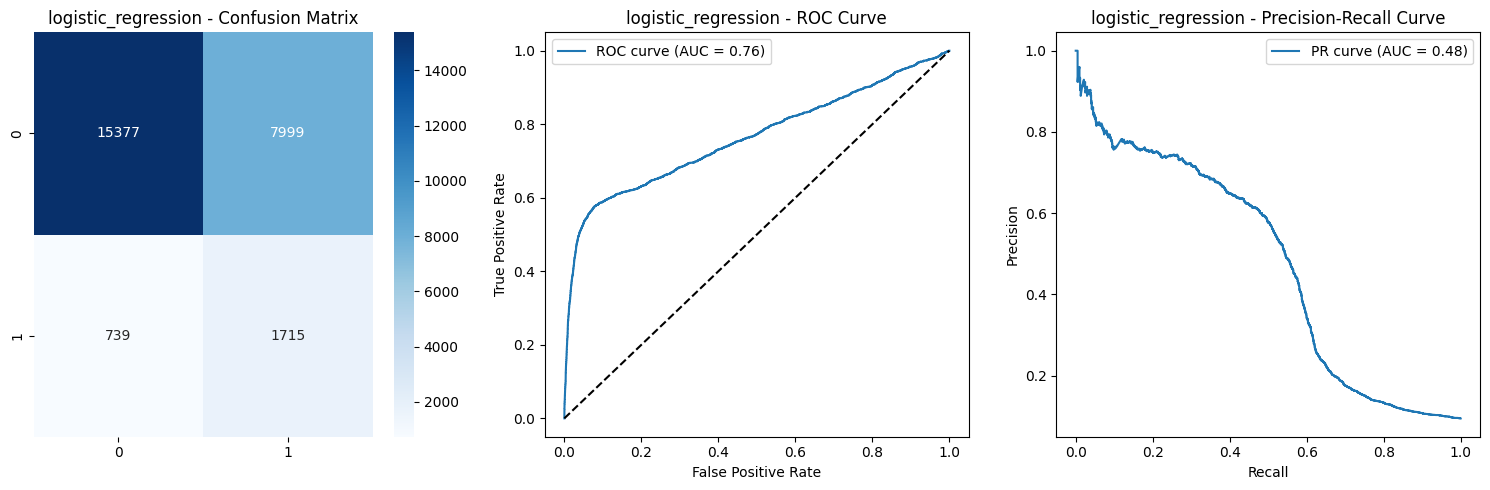

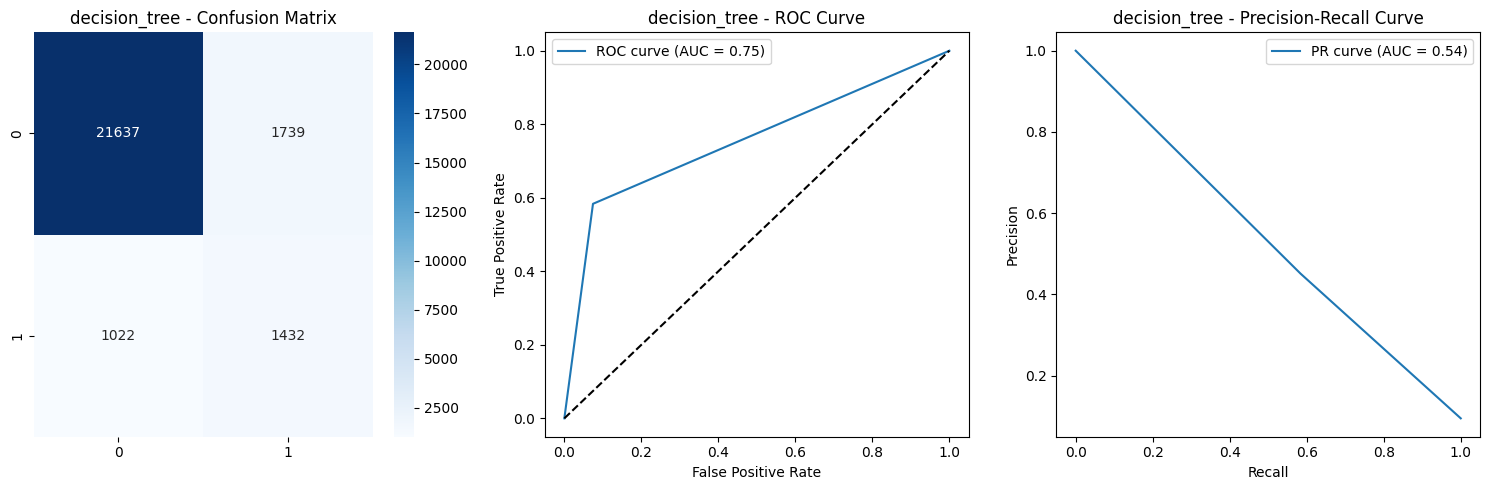

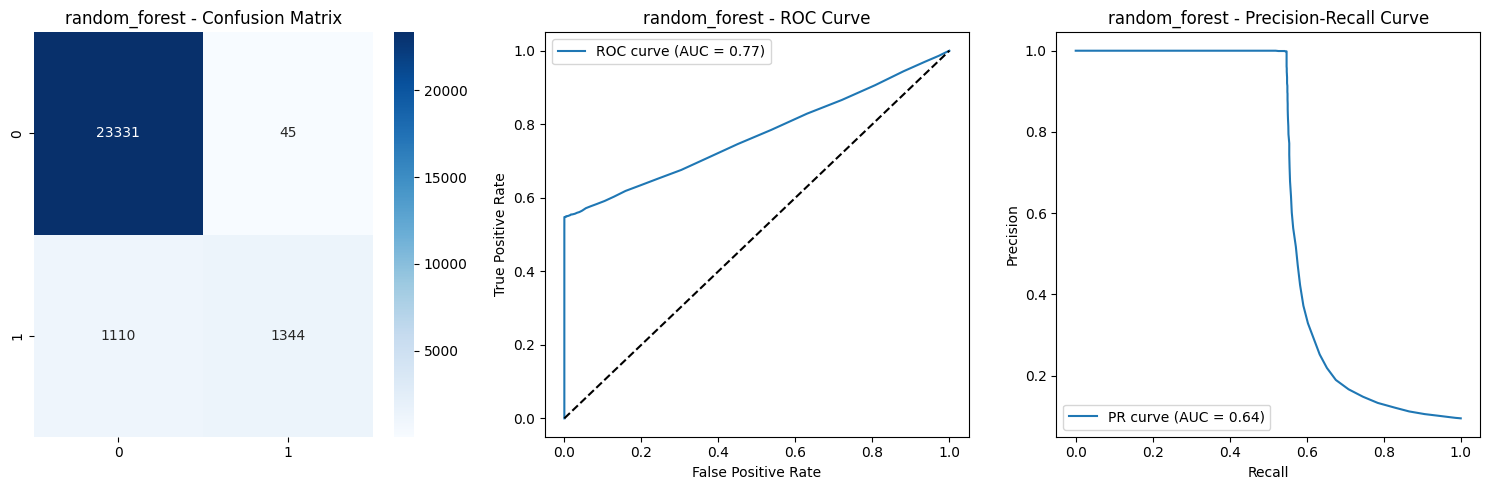

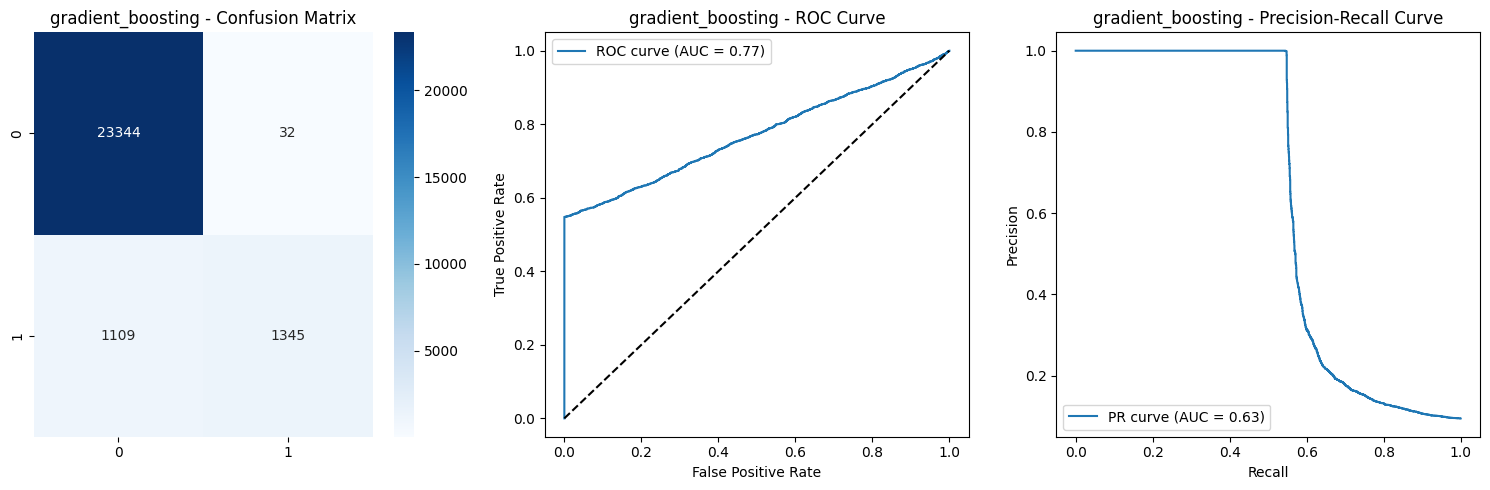

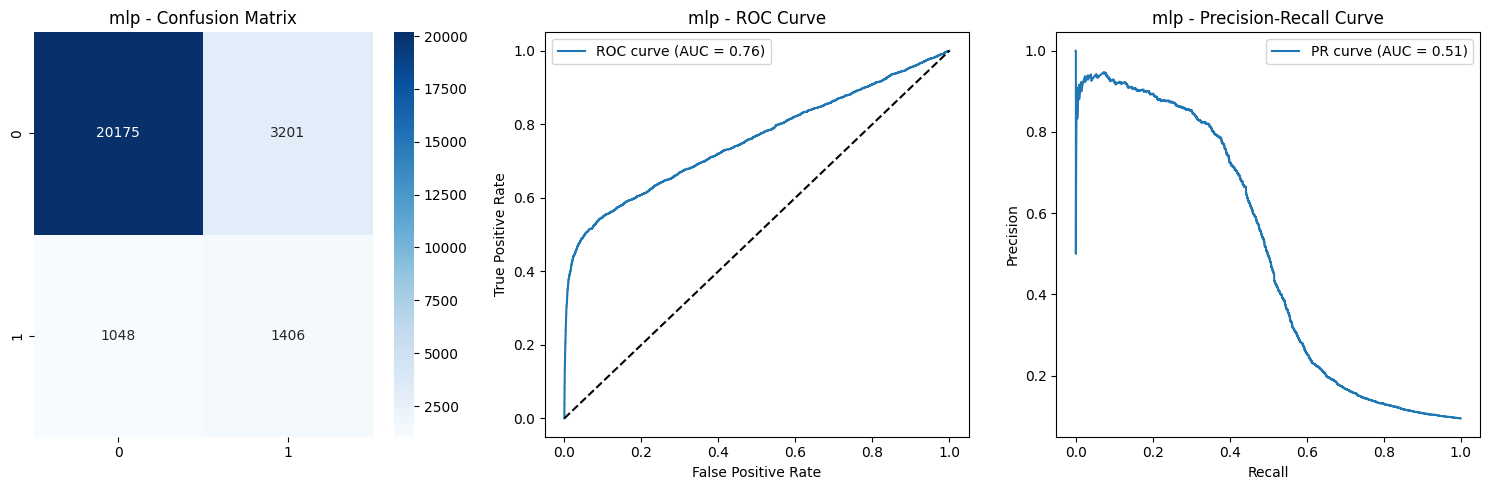

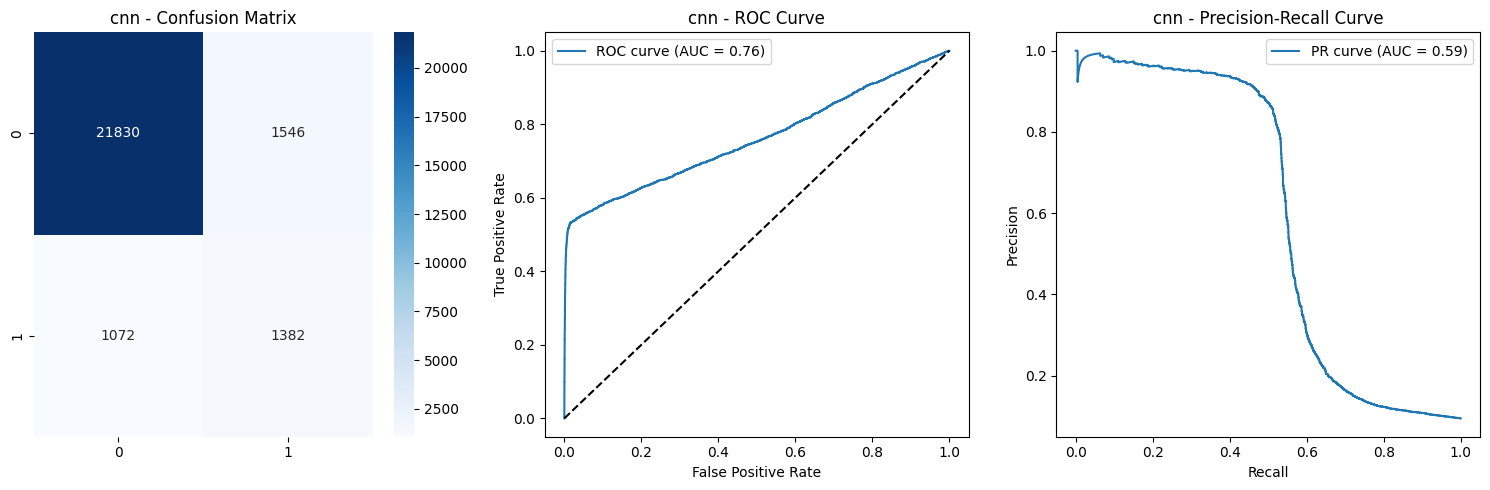

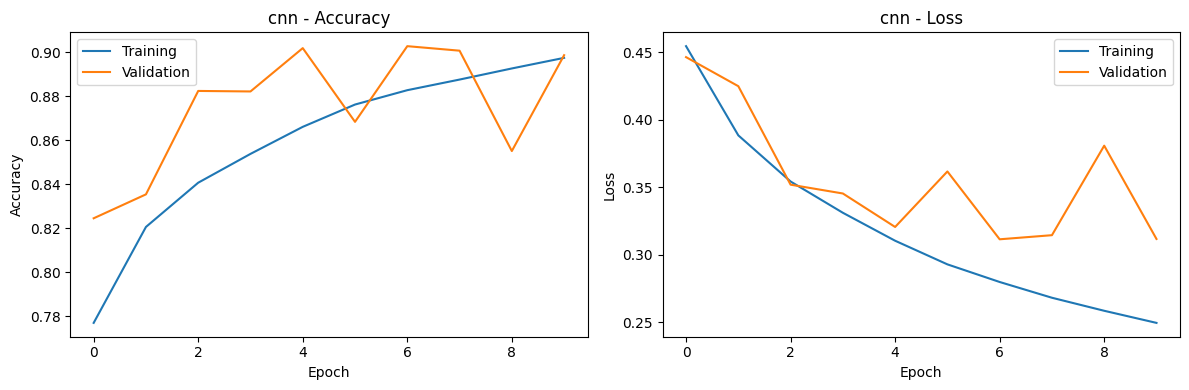

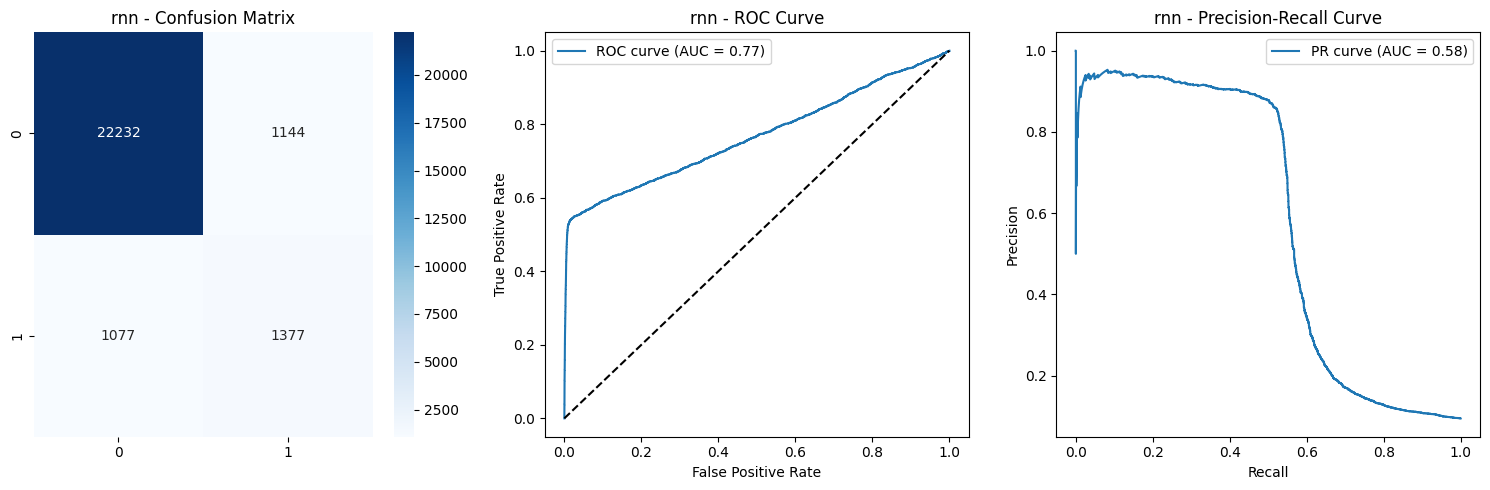

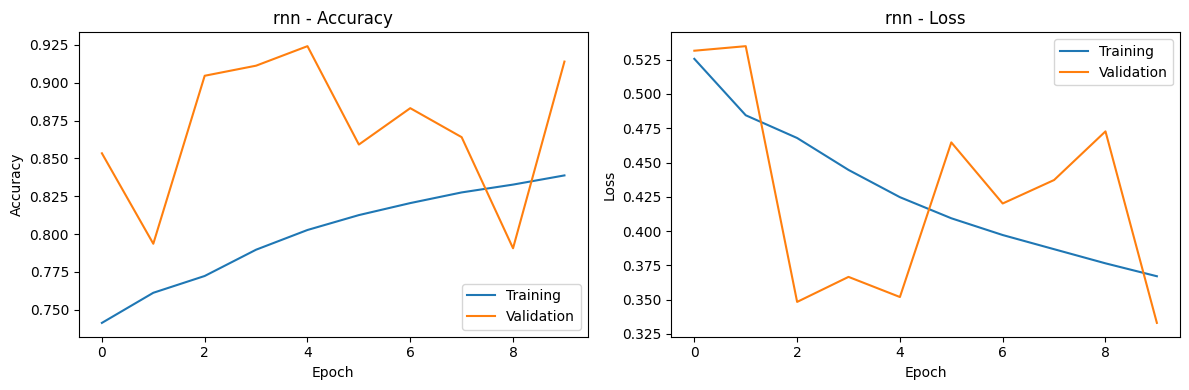

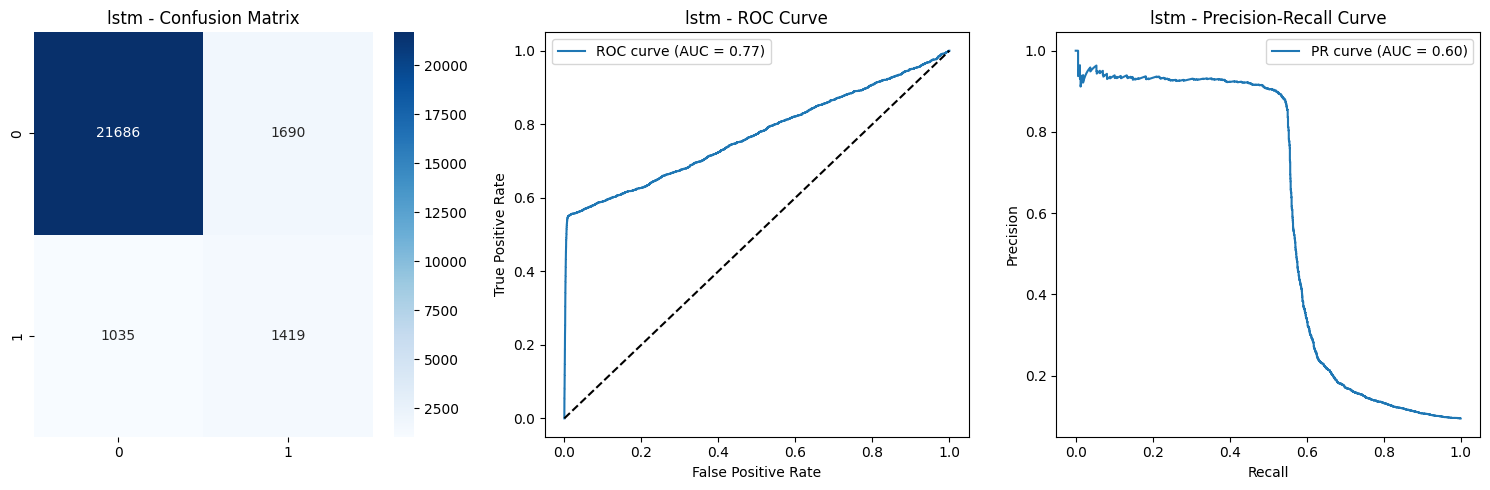

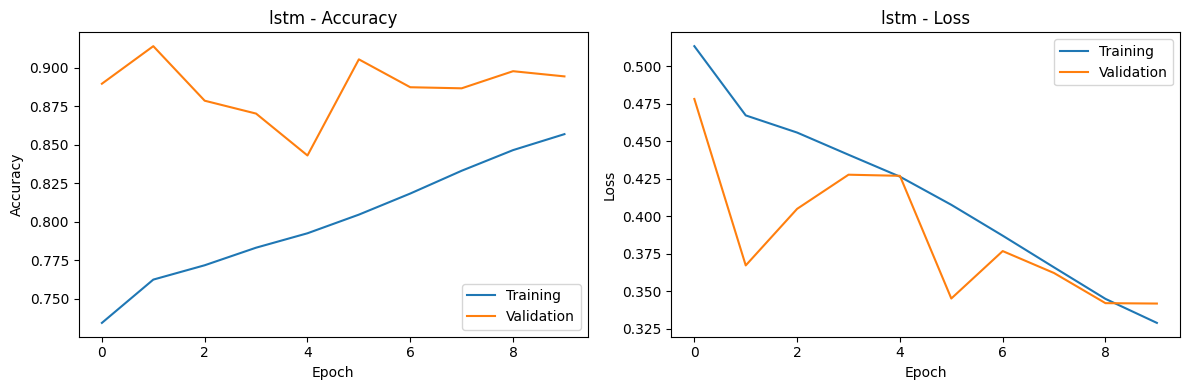

In [25]:
# Plot results for fraud_data models
print("\nE-commerce Fraud Detection Results:")
fraud_detector_ecommerce.plot_results()

### results for credit card fraud models 


Credit Card Fraud Detection Results:


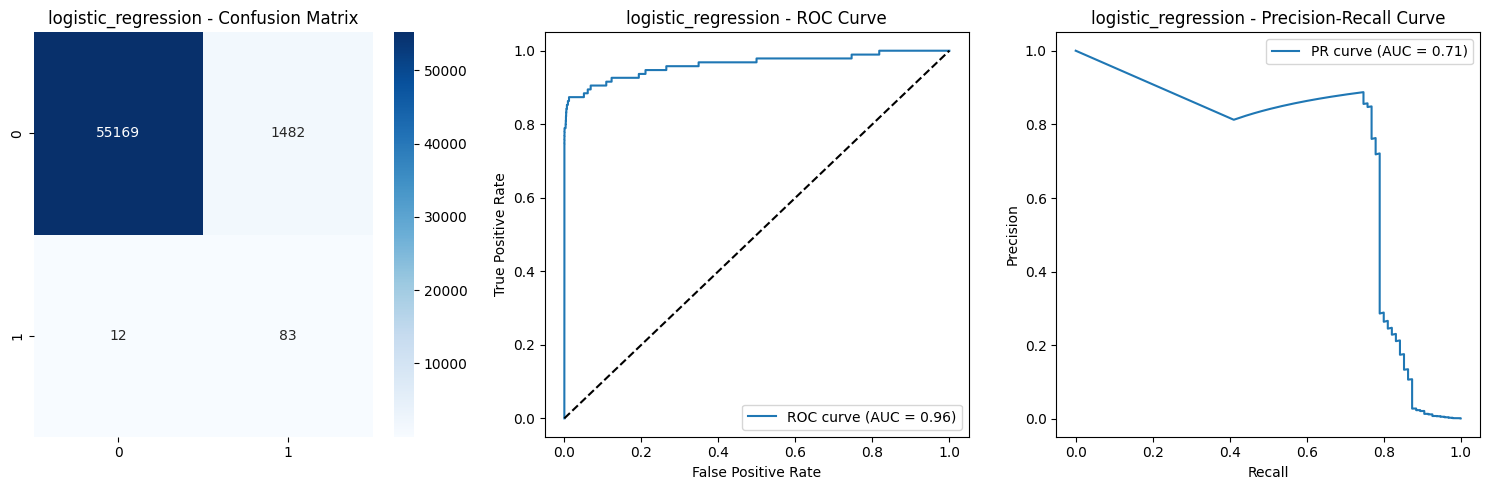

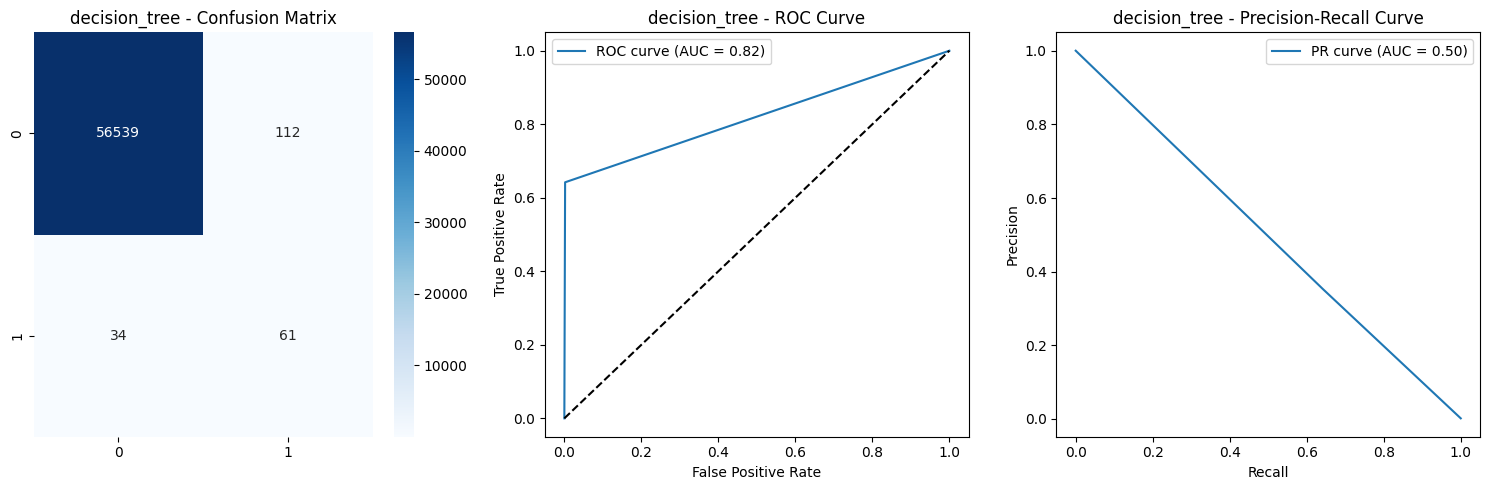

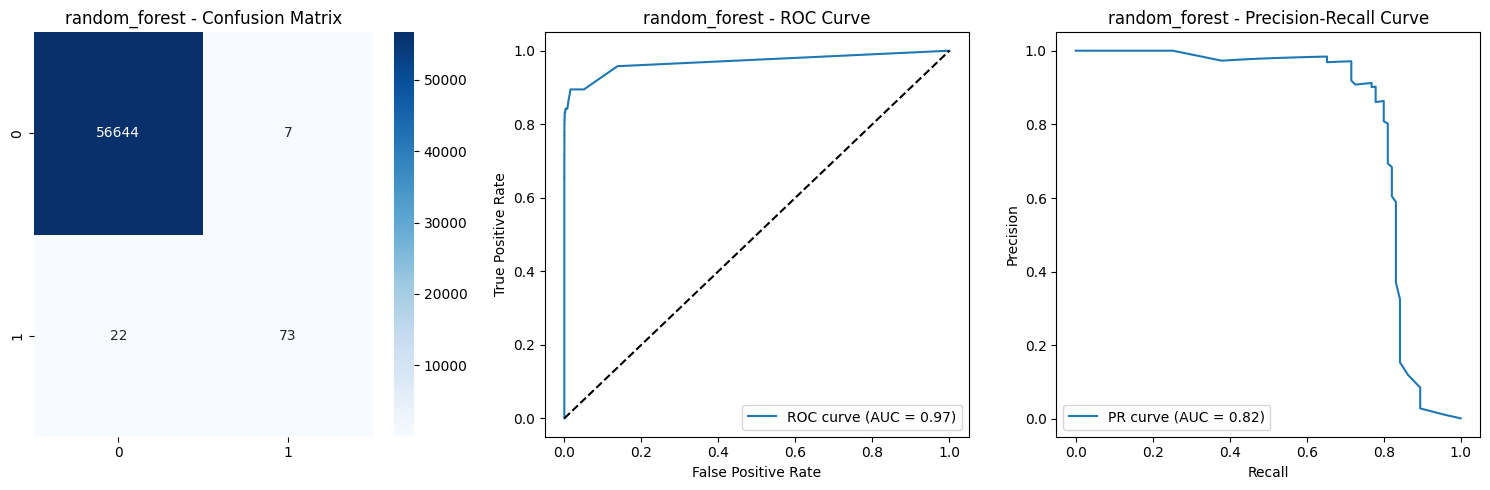

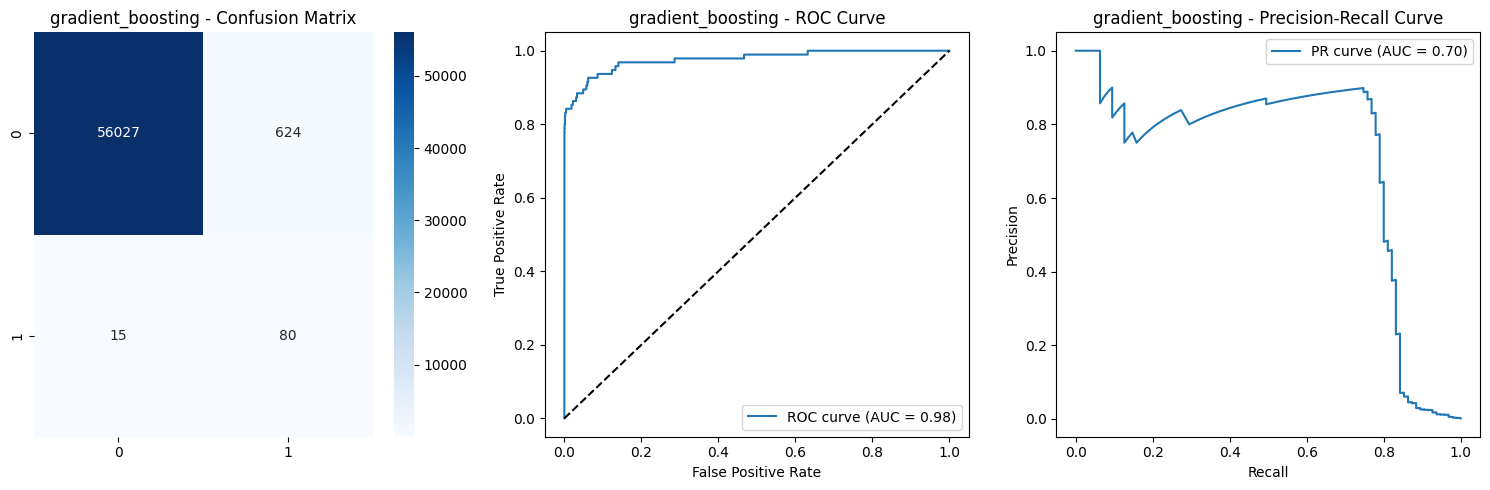

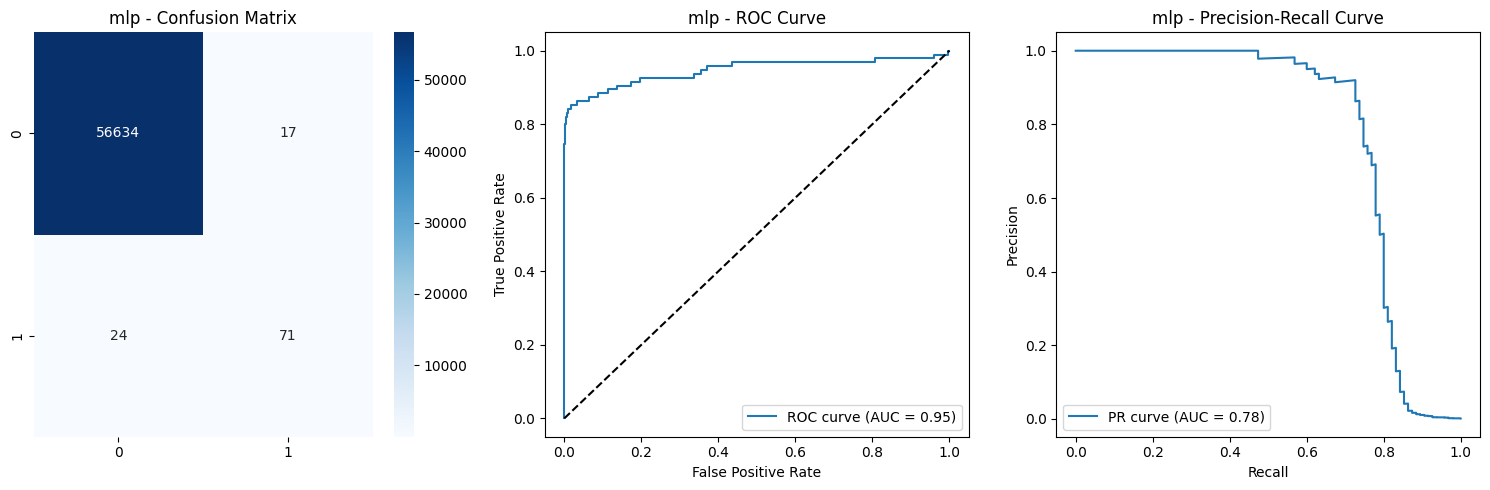

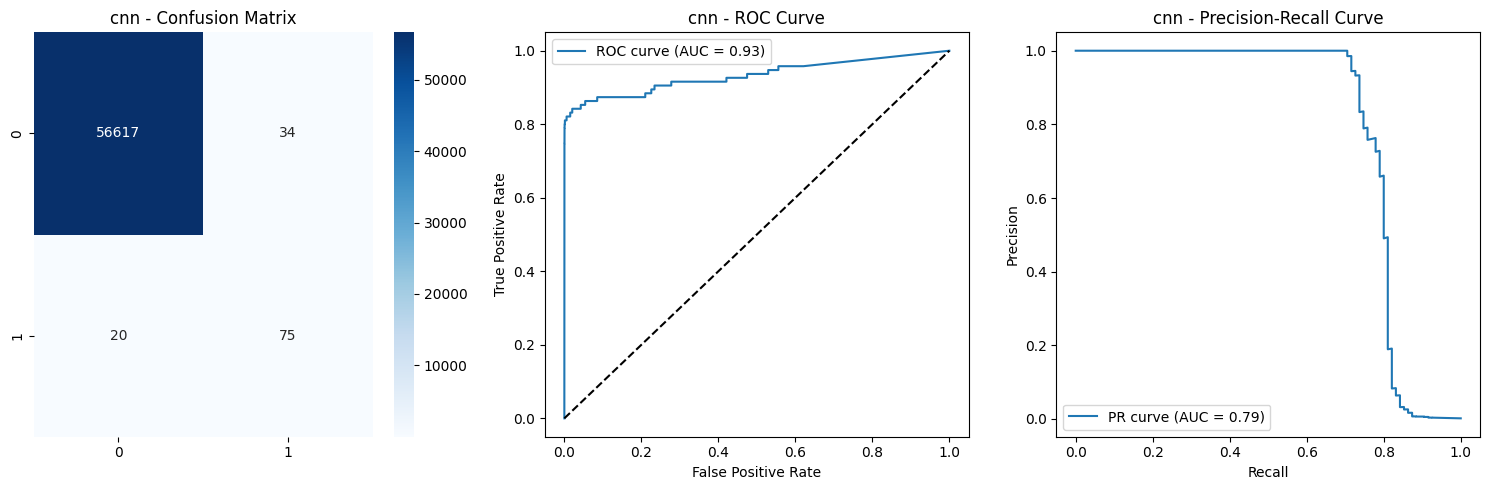

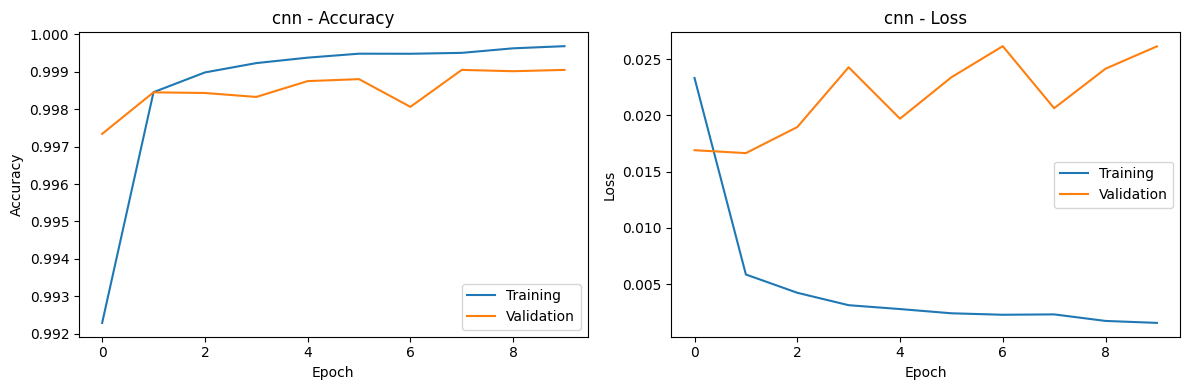

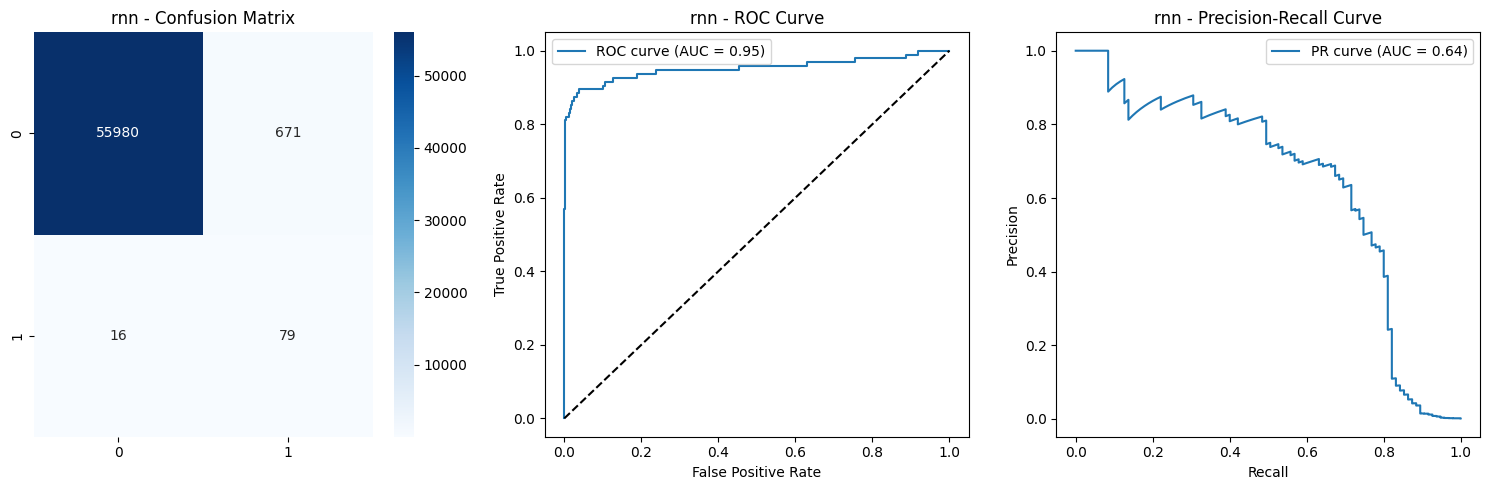

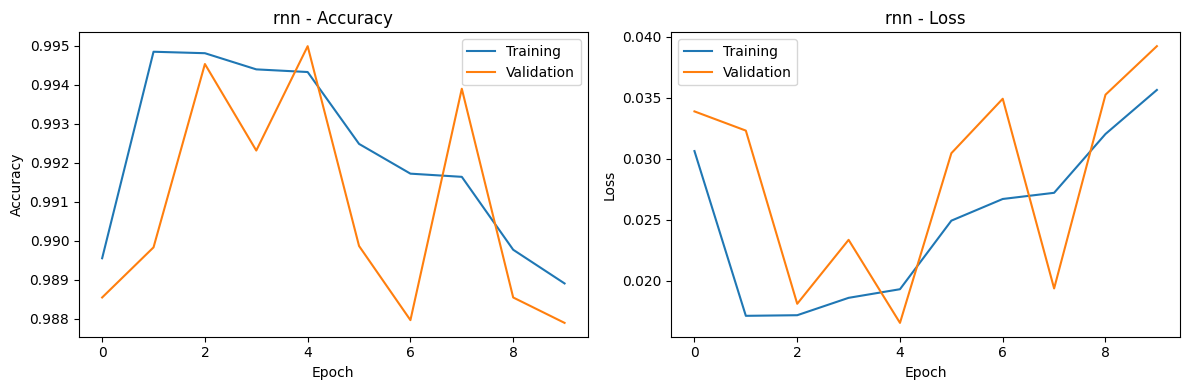

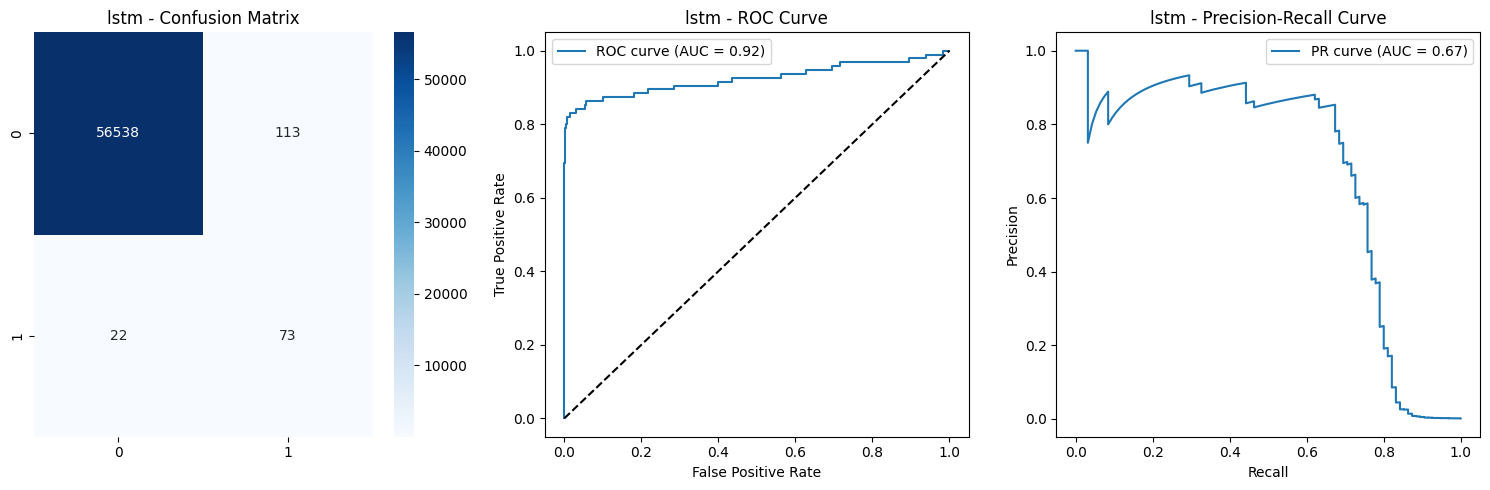

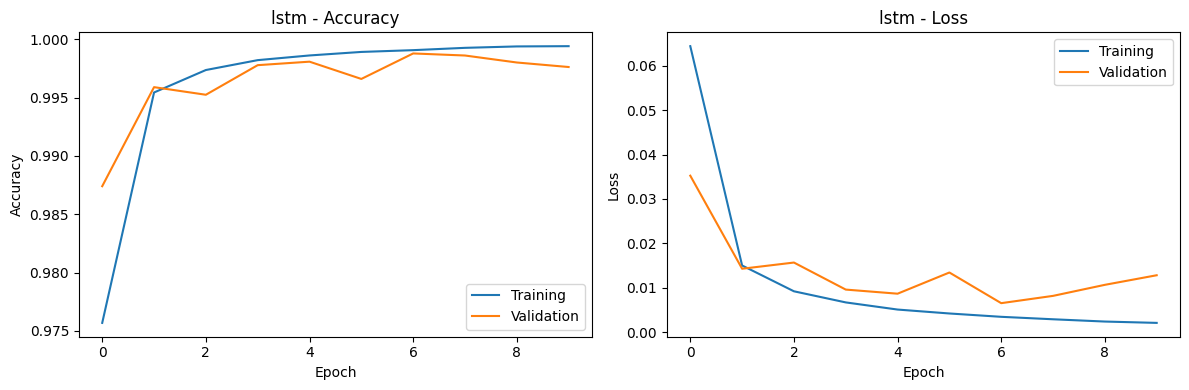

In [26]:
# Plot results for credit card fraud models
print("\nCredit Card Fraud Detection Results:")
fraud_detector_credit.plot_results()

## Compare model performances

In [27]:
# Compare model performances
def print_model_comparison(detector, dataset_name):
    print(f"\nModel Performance Comparison for {dataset_name}:")
    print("-" * 80)
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC-ROC':<10}")
    print("-" * 80)
    
    for model_name, results in detector.results.items():
        if 'classification_report' in results:
            metrics = results['classification_report']
            auc_roc = results['roc_curve'][2]
            print(f"{model_name:<20} "
                  f"{metrics['accuracy']:<10.3f} "
                  f"{metrics['weighted avg']['precision']:<10.3f} "
                  f"{metrics['weighted avg']['recall']:<10.3f} "
                  f"{metrics['weighted avg']['f1-score']:<10.3f} "
                  f"{auc_roc:<10.3f}")

In [28]:
print("\nComparing model performances for E-commerce Fraud Detection")
print_model_comparison(fraud_detector_ecommerce, "E-commerce Fraud Detection")


Comparing model performances for E-commerce Fraud Detection

Model Performance Comparison for E-commerce Fraud Detection:
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1-Score   AUC-ROC   
--------------------------------------------------------------------------------
logistic_regression  0.662      0.880      0.662      0.732      0.764     
decision_tree        0.893      0.907      0.893      0.899      0.755     
random_forest        0.955      0.956      0.955      0.950      0.769     
gradient_boosting    0.956      0.957      0.956      0.950      0.771     
mlp                  0.836      0.889      0.836      0.857      0.755     
cnn                  0.899      0.907      0.899      0.903      0.761     
rnn                  0.914      0.915      0.914      0.915      0.767     
lstm                 0.895      0.907      0.895      0.900      0.770     


In [29]:
print("\nComparing model performances for E-commerce Fraud Detection")
print_model_comparison(fraud_detector_credit, "Credit Card Fraud Detection")


Comparing model performances for E-commerce Fraud Detection

Model Performance Comparison for Credit Card Fraud Detection:
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1-Score   AUC-ROC   
--------------------------------------------------------------------------------
logistic_regression  0.974      0.998      0.974      0.985      0.963     
decision_tree        0.997      0.998      0.997      0.998      0.820     
random_forest        0.999      0.999      0.999      0.999      0.969     
gradient_boosting    0.989      0.998      0.989      0.993      0.977     
mlp                  0.999      0.999      0.999      0.999      0.946     
cnn                  0.999      0.999      0.999      0.999      0.933     
rnn                  0.988      0.998      0.988      0.993      0.952     
lstm                 0.998      0.999      0.998      0.998      0.924     


In [30]:
# Save best models
print("\nSaving best models...")

def get_best_model(detector):
    best_f1 = 0
    best_model_name = None
    
    for model_name, results in detector.results.items():
        if 'classification_report' in results:
            f1 = results['classification_report']['weighted avg']['f1-score']
            if f1 > best_f1:
                best_f1 = f1
                best_model_name = model_name
    
    return best_model_name, detector.models[best_model_name]


Saving best models...


In [31]:
# save best models
with mlflow.start_run(run_name="best_models"):
    # Save best e-commerce fraud model
    best_ecommerce_model_name, best_ecommerce_model = get_best_model(fraud_detector_ecommerce)
    mlflow.sklearn.log_model(best_ecommerce_model, "best_ecommerce_fraud_model")
    print(f"\nBest model for E-commerce Fraud Detection: {best_ecommerce_model_name}")
    
    # Save best credit card fraud model
    best_credit_model_name, best_credit_model = get_best_model(fraud_detector_credit)
    mlflow.sklearn.log_model(best_credit_model, "best_credit_fraud_model")
    print(f"Best model for Credit Card Fraud Detection: {best_credit_model_name}")

print("\nModel training and evaluation completed!")

2024/10/30 17:56:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Best model for E-commerce Fraud Detection: gradient_boosting


2024/10/30 17:56:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best model for Credit Card Fraud Detection: random_forest

Model training and evaluation completed!


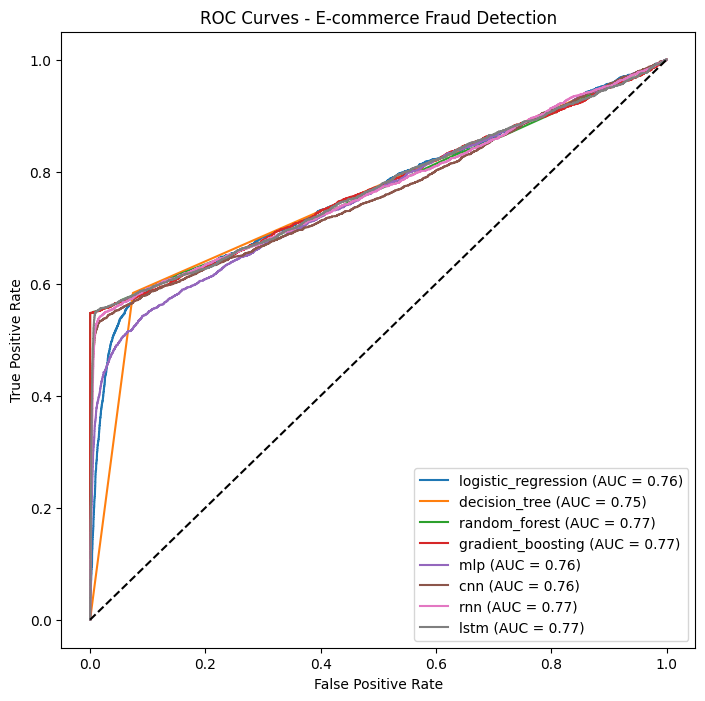

In [32]:
# Generate summary visualizations
plt.figure(figsize=(18, 8))

# ROC curves for all models (E-commerce)
plt.subplot(1, 2, 1)
for model_name, results in fraud_detector_ecommerce.results.items():
    if 'roc_curve' in results:
        fpr, tpr, auc_score = results['roc_curve']
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - E-commerce Fraud Detection')
plt.legend()
plt.show()

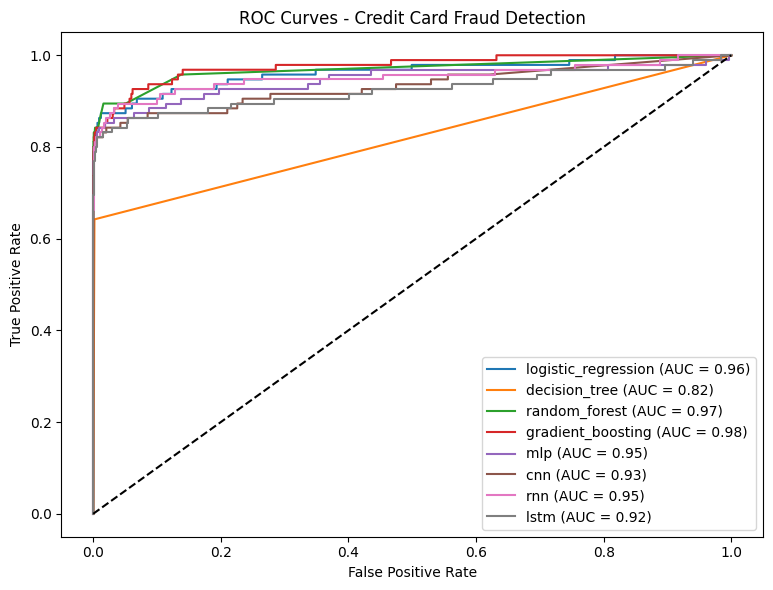

In [33]:
# ROC curves for all models (Credit Card)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 2)
for model_name, results in fraud_detector_credit.results.items():
    if 'roc_curve' in results:
        fpr, tpr, auc_score = results['roc_curve']
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Credit Card Fraud Detection')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# Save the models and scalers for later use
# Save the best models and their corresponding scalers
joblib.dump(best_ecommerce_model, '../models/model_features/best_ecommerce_fraud_model.joblib')
joblib.dump(best_credit_model, '../models/model_features/best_credit_fraud_model.joblib')
joblib.dump(fraud_detector_ecommerce.scaler, '../models/model_features/ecommerce_scaler.joblib')
joblib.dump(fraud_detector_credit.scaler, '../models/model_features/credit_scaler.joblib')

print("\nBest models and scalers have been saved to disk!")


Best models and scalers have been saved to disk!


## Task 3 - Model Explainability
Model Explainability using SHAP and LIME for fraud detection models. 

In [53]:
import lime
import shap
import lime.lime_tabular
class ModelExplainer:
    def __init__(self, model, X_train, X_test, feature_names):
        """
        Initialize the ModelExplainer class
        
        Parameters:
        -----------
        model: trained model object
        X_train: training data
        X_test: test data
        feature_names: list of feature names
        """
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.feature_names = feature_names
        self.shap_values = None
        self.explainer = None
        
    def initialize_shap_explainer(self):
        """Initialize SHAP explainer based on model type"""
        try:
            # For tree-based models
            if hasattr(self.model, 'predict_proba') and hasattr(self.model, 'estimators_'):
                self.explainer = shap.TreeExplainer(self.model)
            # For other models
            else:
                self.explainer = shap.KernelExplainer(
                    self.model.predict_proba, 
                    shap.sample(self.X_train, 100)
                )
            print("SHAP explainer initialized successfully")
        except Exception as e:
            print(f"Error initializing SHAP explainer: {str(e)}")
            
    def calculate_shap_values(self):
        """Calculate SHAP values for the test set"""
        if self.explainer is None:
            self.initialize_shap_explainer()
        
        try:
            self.shap_values = self.explainer.shap_values(self.X_test)
            # If shap_values is a list (for binary classification), take the positive class
            if isinstance(self.shap_values, list):
                self.shap_values = self.shap_values[1]
            print("SHAP values calculated successfully")
        except Exception as e:
            print(f"Error calculating SHAP values: {str(e)}")
            
    def plot_shap_summary(self):
        """Create SHAP summary plot"""
        if self.shap_values is None:
            self.calculate_shap_values()
            
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            self.shap_values, 
            self.X_test,
            feature_names=self.feature_names,
            show=False
        )
        plt.title("SHAP Summary Plot")
        plt.tight_layout()
        plt.show()


    def plot_shap_dependence(self, feature_idx):
        """Create SHAP dependence plot for a specific feature"""
        if self.shap_values is None:
            self.calculate_shap_values()
            
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx,
            self.shap_values,
            self.X_test,
            feature_names=self.feature_names,
            show=False
        )
        plt.title(f"SHAP Dependence Plot - {self.feature_names[feature_idx]}")
        plt.tight_layout()
        plt.show()
        
    def plot_shap_force(self, instance_index):
        """Create SHAP force plot for a specific instance"""
        if self.shap_values is None:
            self.calculate_shap_values()
            
        plt.figure(figsize=(15, 3))
        shap.force_plot(
            self.explainer.expected_value,
            self.shap_values[instance_index],
            self.X_test.iloc[instance_index],
            feature_names=self.feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f"SHAP Force Plot - Instance {instance_index}")
        plt.tight_layout()
        plt.show()
        
    def initialize_lime_explainer(self):
        """Initialize LIME explainer"""
        try:
            self.lime_explainer = lime.lime_tabular.LimeTabularExplainer(
               self.X_train.values if isinstance(self.X_train, pd.DataFrame) else self.X_train,
                feature_names=self.feature_names,
                class_names=['Not Fraud', 'Fraud'],
                mode='classification'
            )

            
            print("LIME explainer initialized successfully")
        except Exception as e:
            print(f"Error initializing LIME explainer: {str(e)}")
            
    def explain_instance_lime(self, instance_index, num_features=10):
        """
        Create LIME explanation for a specific instance
        
        Parameters:
        -----------
        instance_index: index of the instance to explain
        num_features: number of features to include in the explanation
        """
        if not hasattr(self, 'lime_explainer'):
            self.initialize_lime_explainer()
            
        try:
            explanation = self.lime_explainer.explain_instance(
                self.X_test.iloc[instance_index].values,
                self.model.predict_proba,
                num_features=num_features
            )
            
            # Plot the explanation
            plt.figure(figsize=(10, 6))
            explanation.as_pyplot_figure()
            plt.title(f"LIME Explanation - Instance {instance_index}")
            plt.tight_layout()
            plt.show()
            
            return explanation
        except Exception as e:
            print(f"Error generating LIME explanation: {str(e)}")   

In [54]:
# Initialize explainers
ecommerce_explainer = ModelExplainer(
        best_ecommerce_model,
        X_fraud.iloc[:-100],  # Use part of data for training
        X_fraud.iloc[-100:],  # Use last 100 samples for testing
        X_fraud.columns.tolist()
    )
    
credit_explainer = ModelExplainer(
        best_credit_model,
        X_credit.iloc[:-100],
        X_credit.iloc[-100:],
        X_credit.columns.tolist()
    )

### Generate SHAP explanations


Generating SHAP explanations for E-commerce fraud model...
SHAP explainer initialized successfully
SHAP values calculated successfully


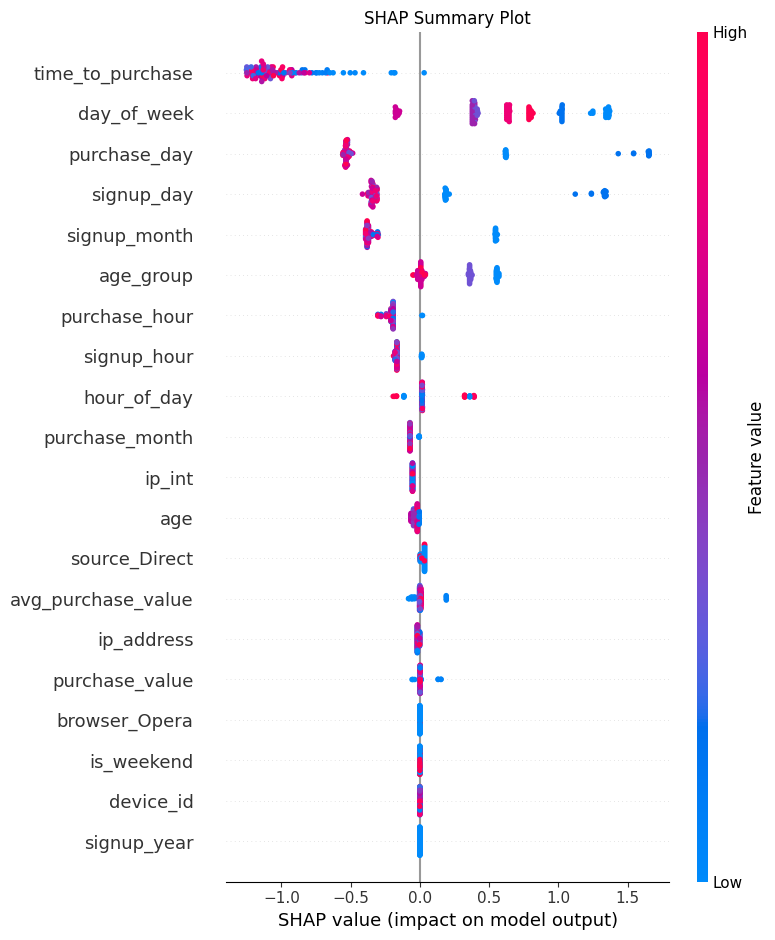

<Figure size 1000x600 with 0 Axes>

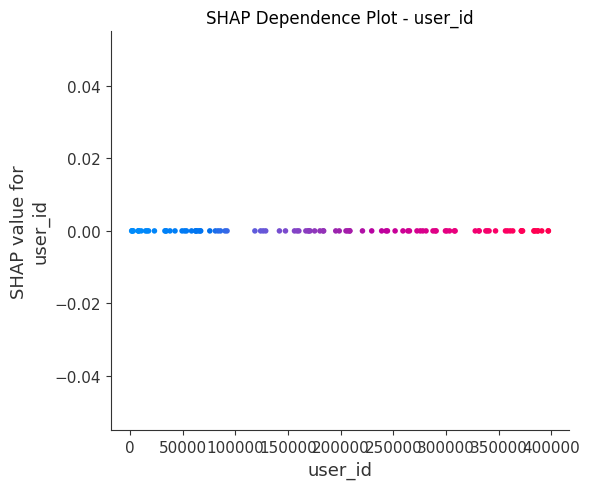

<Figure size 1500x300 with 0 Axes>

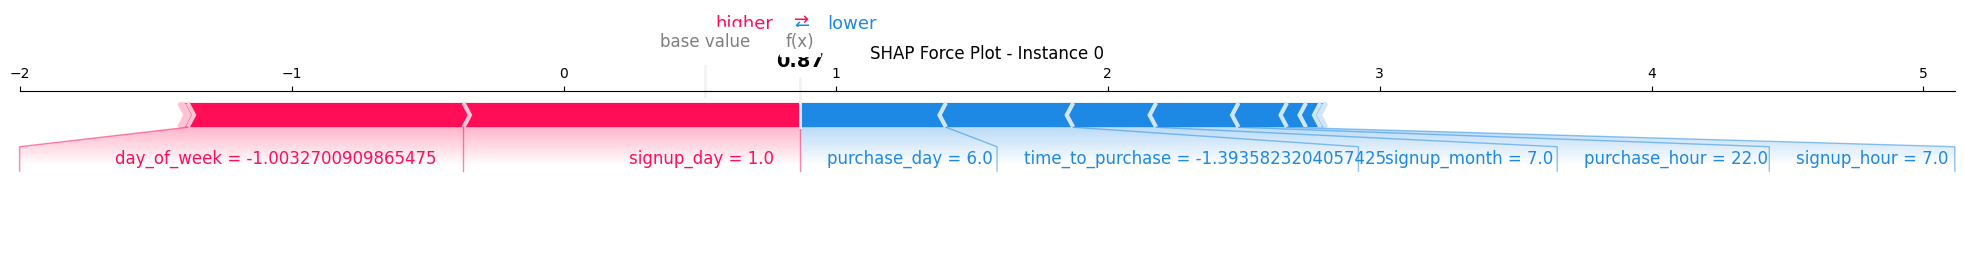

In [55]:
print("\nGenerating SHAP explanations for E-commerce fraud model...")
ecommerce_explainer.plot_shap_summary()
ecommerce_explainer.plot_shap_dependence(0)  # Explain first feature
ecommerce_explainer.plot_shap_force(0)  # Explain first instance

In [ ]:
print("\nGenerating SHAP explanations for Credit card fraud model...")
credit_explainer.plot_shap_summary()
credit_explainer.plot_shap_dependence(0)
credit_explainer.plot_shap_force(0)

### Generate LIME explanations


Generating LIME explanations for E-commerce fraud model...
LIME explainer initialized successfully


<Figure size 1000x600 with 0 Axes>

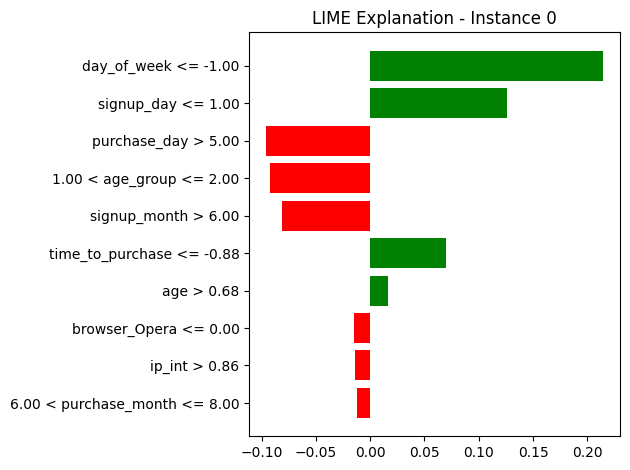

<Figure size 1000x600 with 0 Axes>

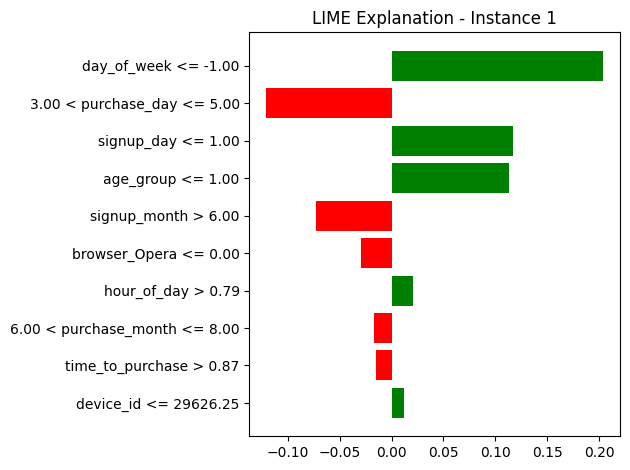

In [56]:
print("\nGenerating LIME explanations for E-commerce fraud model...")
ecommerce_explainer.explain_instance_lime(0)
ecommerce_explainer.explain_instance_lime(1)


Generating LIME explanations for Credit card fraud model...
LIME explainer initialized successfully


<Figure size 1000x600 with 0 Axes>

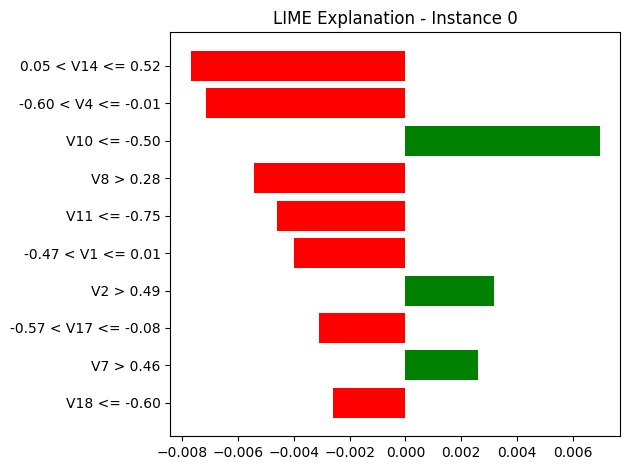

<Figure size 1000x600 with 0 Axes>

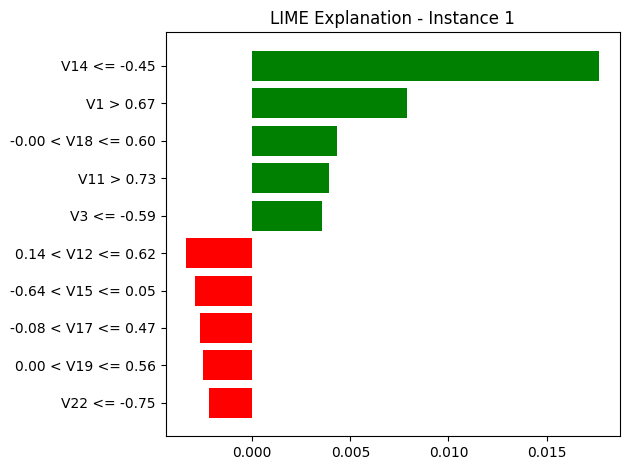

In [57]:
print("\nGenerating LIME explanations for Credit card fraud model...")
credit_explainer.explain_instance_lime(0)
credit_explainer.explain_instance_lime(1)